# Six Southern Labor Markets #5
### Reasons for labor force non-participation

February 10, 2019

Brian Dew, @bd_econ

-----

For the combined years 2017 and 2018, look at why 16-64 year old men and women are not in the labor force, and how this compares to national average. First start with the major example, which is employment including care. Then compare the share of population that is caregiving, disabled/ill, retired, in school, discouraged, or other.

Areas:

- Chattanooga
- Knoxville
- Greenville
- Asheville
- Kingsport
- Huntsville
- US total

In [1]:
import pandas as pd
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [2]:
areas = [('Chattanooga-Cleveland-Dalton, TN-GA', 'CSA', [174]),
         ('Greenville-Anderson-Spartanburg, SC', 'CSA', [273]),
         ('Asheville, NC', 'CBSA', [11700]),
         ('Johnson City-Kingsport-Bristol, TN-VA', 'CSA', [304]),
         ('Huntsville, AL', 'CBSA', [26620]),
         ('Knoxville, TN', 'CBSA', [28940])]

area_names = [area[0] for area in areas]

In [3]:
csa = [area[2][0] for area in areas if area[1] == 'CSA']
cbsa = [area[2][0] for area in areas if area[1] == 'CBSA']
grps = [('US Total', 'AGE > -1')]
grps2 = [(area[0], f'{area[1]} == {area[2][0]}') for area in areas]
groups = grps2 + grps

# Employment with care

In [4]:
# CPS data
os.chdir('/home/brian/Documents/CPS/data/clean')

# Subset of columns of interest
columns = ['MONTH', 'YEAR', 'CBSA', 'CSA', 'AGE', 'STATE', 'REGION',
           'BASICWGT', 'LFS', 'FEMALE', 'NILFREASON']

df = pd.concat([pd.read_feather(f'cps{year}.ft', columns=columns)
                for year in [2017, 2018]])

In [5]:
# Collect results for total, men, women in each area
results = pd.DataFrame()
for group in groups:
    data = df.query(group[1])
    data = data.query('16 <= AGE <= 64')
    row_name = f'{group[0]}, Total'
    emp = (data.query('LFS == "Employed"').BASICWGT.sum() / 
           data.BASICWGT.sum()) * 100.0
    results.at[row_name, 'Employed'] = emp
    care = (data.query('NILFREASON == "Family"').BASICWGT.sum() / 
            data.BASICWGT.sum()) * 100.0
    results.at[row_name, 'Care'] = care
    men = data.query('FEMALE == 0')
    row_name = f'{group[0]}, Men'
    emp = (men.query('LFS == "Employed"').BASICWGT.sum() / 
           men.BASICWGT.sum()) * 100.0
    results.at[row_name, 'Employed'] = emp
    care = (men.query('NILFREASON == "Family"').BASICWGT.sum() / 
            men.BASICWGT.sum()) * 100.0
    results.at[row_name, 'Care'] = care
    women = data.query('FEMALE == 1')    
    row_name = f'{group[0]}, Women'
    emp = (women.query('LFS == "Employed"').BASICWGT.sum() / 
           women.BASICWGT.sum()) * 100.0
    results.at[row_name, 'Employed'] = emp
    care = (women.query('NILFREASON == "Family"').BASICWGT.sum() / 
            women.BASICWGT.sum()) * 100.0
    results.at[row_name, 'Care'] = care
    
results['Total'] = results['Employed'] + results['Care']

### Clean up results and sort

In [6]:
# Custom sort - most employed first, US total last
filter_list = [area for area in list(results.index) 
               if 'US' not in area and 'Total' in area]
sorted_list = list(results.loc[filter_list]
                           .sort_values(by='Total')
                           .index)
sorted_names = [i.replace(', Total', '') for i in sorted_list]

m_w_list = [(i.replace('Total', 'Men'), i.replace('Total', 'Women'))
            for i in sorted_list]
temp_list = [('US Total, Men', 'US Total, Women')] + m_w_list
row_list = list(sum(temp_list, ()))

results = results.loc[row_list]

areas = ['US Total'] + sorted_names

In [7]:
# Get start location for each bar segment
temp = results.cumsum(axis=1).iloc[:,:-1]
temp['start'] = 0
temp = temp[['start', 'Employed']]
start_locs = temp.rename({'start': 'Employed', 'Employed': 'Care'}, axis=1)

# Get length of each bar segment
len_locs = results

# Get y values for each bar (with blank space for label)
y_values = []
i = 0.0
for _ in range(7):
    y_values.extend([i, i+1])
    i = i + 2.8
    
tot_label_locs = results['Total'].values

# Color for each LFS group (blue, dark blue)
colors = ['#6baed6', '#08519c']

# Combine lfs group names with colors
lfs_groups = list(zip(colors, ['Employed', 'Care']))

In [8]:
# Main city name labels
label_y_locs = [y + 2 for y in y_values[::2]]
area_labels = list(zip(areas, label_y_locs))

# Men/ Women labels
label_y_locs = y_values
label_text = ['M', 'F'] * 7
mw_labels = list(zip(label_y_locs, label_text))

### Employment and care chart

In [9]:
os.chdir('/home/brian/Documents/blog_posts/Southern_Six/')

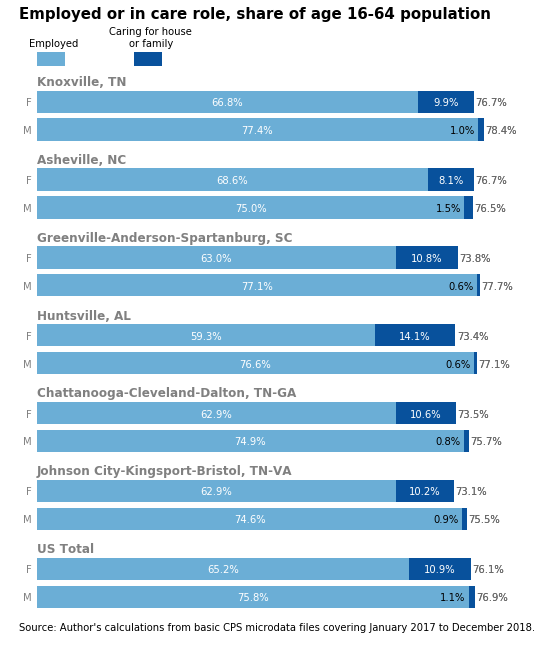

In [10]:
# Very custom stacked horizontal bar chart
fig = plt.figure(figsize=(9,11))

plt.ylim(-0.5, 21)
plt.xlim(0, 88)

ax = plt.gca()
    
for color, lfs_level in lfs_groups:
    bar_segments = []
    start_loc = start_locs[lfs_level].values
    len_loc = len_locs[lfs_level].values
    data = list(zip(start_loc, len_loc, y_values, tot_label_locs))
    for seg in data:
        rect = Rectangle((seg[0], seg[2]), seg[1], 0.8)
        bar_segments.append(rect)
        
        # Put data value text at bar midpoint
        text_x_val = (seg[1] / 2 + seg[0])
        text_color = 'white'
        if seg[1] < 2:
            text_x_val = seg[0] - 2.8
            text_color = 'black'
        text_y_val = seg[2] + 0.275
        text_val = f'{round(seg[1], 1)}%'
        plt.text(text_x_val, text_y_val, text_val,
                 fontsize=10, color=text_color, ha='center')
        
        # Plot total value at end of bar
        tot_x_val = seg[3] + 3
        tot_text_val = f'{round(seg[3], 1)}%'
        tot_y_val = seg[2] + 0.275
        text_color = 'dimgray'
        plt.text(tot_x_val, tot_y_val, tot_text_val,
                 fontsize=10, color=text_color, ha='center')        

    bars = PatchCollection(bar_segments, facecolor=color, edgecolor='none')
                        
    ax.add_collection(bars)

for name, y_loc in area_labels:
    plt.text(0, y_loc, name, fontsize=12, color='gray', weight='bold')

for y_loc, name in mw_labels:
    plt.text(-0.8, y_loc + 0.275, name, fontsize=10, color='gray', ha='right')
    
# Custom legend at top of plot
plt.text(3, 20.2, 'Employed', ha='center')
rect = Rectangle((0, 19.5), 5, 0.5, facecolor='#6baed6', edgecolor='none')
ax.add_patch(rect)

plt.text(20, 20.2, 'Caring for house\nor family', ha='center')
rect = Rectangle((17, 19.5), 5, 0.5, facecolor='#08519c', edgecolor='none')
ax.add_patch(rect)

    
# add title and footer
plt.text(-3, 21.2, 'Employed or in care role, share of age 16-64 population', 
          fontsize=15, weight='bold')

plt.text(-3, -0.8, "Source: Author's calculations from basic CPS microdata files covering January 2017 to December 2018.")

plt.axis('off')

plt.savefig('epopcare.png', bbox_inches='tight');

### Reasons for non-participation in the labor force

In [11]:
# Collect results for total, men, women in each area
results = pd.DataFrame()
for group in groups:
    data = df.query(group[1])
    data = data.query('16 <= AGE <= 64')
    i = data.groupby('NILFREASON').BASICWGT.sum()
    s = ((i / data.BASICWGT.sum()) * 100)
    for idx, val in s.iteritems():
        row_name = f'{group[0]}, Total'
        results.at[row_name, idx] = val    
    men = data.query('FEMALE == 0')
    i = men.groupby('NILFREASON').BASICWGT.sum()
    s = ((i / men.BASICWGT.sum()) * 100)
    for idx, val in s.iteritems():
        row_name = f'{group[0]}, Men'
        results.at[row_name, idx] = val
    women = data.query('FEMALE == 1')
    i = women.groupby('NILFREASON').BASICWGT.sum()
    s = ((i / women.BASICWGT.sum()) * 100)
    for idx, val in s.iteritems():
        row_name = f'{group[0]}, Women'
        results.at[row_name, idx] = val
        
results = results.drop(['nan'], axis=1)

results['Total'] = results.sum(axis=1)

results = results.drop(['Other', 'Family'], axis=1)

results = results[['Disabled/Ill', 'Retired', 'School', 'Discouraged', 'Total']]

### Sort data

In [12]:
# Custom sort - most employed first, US total last
filter_list = [area for area in list(results.index) 
               if 'US' not in area and 'Total' in area]
sorted_list = list(results.loc[filter_list]
                           .sort_values(by='Total')
                           .index)
sorted_names = [i.replace(', Total', '') for i in sorted_list]

m_w_list = [(i.replace('Total', 'Men'), i.replace('Total', 'Women'))
            for i in sorted_list]
temp_list = [('US Total, Men', 'US Total, Women')] + m_w_list
row_list = list(sum(temp_list, ()))

results = results.loc[row_list]

areas = ['US Total'] + sorted_names

In [13]:
# Get start location for each bar segment
temp = results.cumsum(axis=1).iloc[:,:-1]
temp['start'] = 0
temp = temp[['start', 'Disabled/Ill', 'Retired', 'School']]
start_locs = temp.rename({'start': 'Disabled/Ill', 
                          'Disabled/Ill': 'Retired',
                          'Retired': 'School',
                          'School': 'Discouraged'}, axis=1)

# Get length of each bar segment
len_locs = results

# Get y values for each bar (with blank space for label)
y_values = []
i = 0.0
for _ in range(7):
    y_values.extend([i, i+1])
    i = i + 2.8
    
tot_label_locs = results['Total'].values

# Color for each educational group (red, blue, green, purple, orange)
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']

# Combine lfs group names with colors
nilf_groups = list(zip(colors, ['Disabled/Ill', 'Retired', 'School', 'Discouraged']))

In [14]:
# Main city name labels
label_y_locs = [y + 2 for y in y_values[::2]]
area_labels = list(zip(areas, label_y_locs))

# Men/ Women labels
label_y_locs = y_values
label_text = ['M', 'F'] * 7
mw_labels = list(zip(label_y_locs, label_text))

### Reason for non-participation chart

In [15]:
os.chdir('/home/brian/Documents/blog_posts/Southern_Six/')

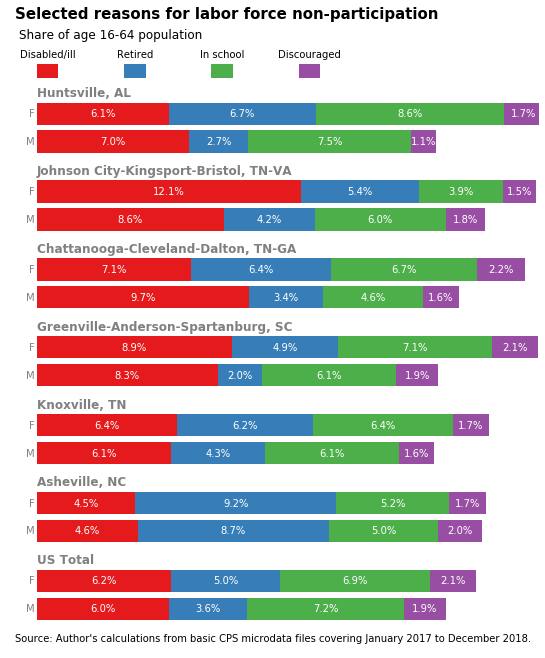

In [31]:
# Very custom stacked horizontal bar chart
fig = plt.figure(figsize=(9,11))

plt.ylim(-0.5, 21)
plt.xlim(0, 23)

ax = plt.gca()
    
for color, nilf_group in nilf_groups:
    bar_segments = []
    start_loc = start_locs[nilf_group].values
    len_loc = len_locs[nilf_group].values
    data = list(zip(start_loc, len_loc, y_values))
    for seg in data:
        rect = Rectangle((seg[0], seg[2]), seg[1], 0.8)
        bar_segments.append(rect)
        
        # Put data value text at bar midpoint
        text_x_val = (seg[1] / 2 + seg[0])
        text_y_val = seg[2] + 0.275
        text_val = f'{round(seg[1], 1)}%'
        plt.text(text_x_val, text_y_val, text_val,
                 fontsize=10, color='white', ha='center')

    bars = PatchCollection(bar_segments, facecolor=color, edgecolor='none')
                        
    ax.add_collection(bars)

for name, y_loc in area_labels:
    plt.text(0, y_loc, name, fontsize=12, color='gray', weight='bold')

for y_loc, name in mw_labels:
    plt.text(-0.1, y_loc + 0.275, name, fontsize=10, color='gray', ha='right')
    
# Custom legend at top of plot
plt.text(0.5, 20.2, 'Disabled/ill', ha='center')
rect = Rectangle((0, 19.5), 1, 0.5, facecolor='#e41a1c', edgecolor='none')
ax.add_patch(rect)

plt.text(4.5, 20.2, 'Retired', ha='center')
rect = Rectangle((4, 19.5), 1, 0.5, facecolor='#377eb8', edgecolor='none')
ax.add_patch(rect)

plt.text(8.5, 20.2, 'In school', ha='center')
rect = Rectangle((8, 19.5), 1, 0.5, facecolor='#4daf4a', edgecolor='none')
ax.add_patch(rect)

plt.text(12.5, 20.2, 'Discouraged', ha='center')
rect = Rectangle((12, 19.5), 1, 0.5, facecolor='#984ea3', edgecolor='none')
ax.add_patch(rect)

# add title and footer
plt.text(-1, 21.6, 'Selected reasons for labor force non-participation', 
          fontsize=15, weight='bold')

plt.text(-0.8, 20.9, "Share of age 16-64 population", fontsize=12)


plt.text(-1, -0.8, "Source: Author's calculations from basic CPS microdata files covering January 2017 to December 2018.")

plt.axis('off')

plt.savefig('nilfreason.png', bbox_inches='tight');